In [ ]:
# мощный алгоритм, по силе как нейронная сеть
# как и сеть, склонен к переобучению. (потому что )
# чем больше деревьев , тем больше вероятность переобучения.


# основная идея бустинга - каждая следующая модель принимает в учет ОШИБКИ предыдущих


# подходит для регрессии и классификации


# беггинг - это когда каждая следующая модель формируется независимо от предыдущей
# бустинг - когда зависима от предыдущей 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import ensemble
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from matplotlib.pylab import rc, plot
%matplotlib inline

from sklearn import metrics
from sklearn import datasets
from sklearn import utils
from sklearn import tree



C:\Users\mosco\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
boston = datasets.load_boston()

In [3]:
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

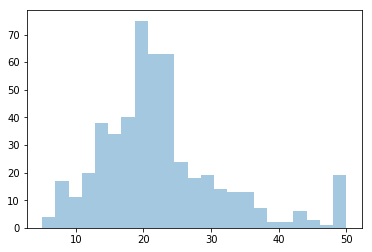

In [4]:
sns.distplot(boston.target, kde=False)

In [5]:
df = pd.DataFrame(boston.data, columns=boston.feature_names)

In [6]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [7]:
type(boston)

sklearn.utils.Bunch

In [8]:
# learning_rate - параметр, управляющий переобучением. то есть чем он меньше, тем меньше вероятность переобучения.

class MyGradientBoostingRegressor(object):
    def __init__(self, n_estimators=100, max_depth=4, min_samples_split=2, learning_rate=0.01):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.learning_rate = learning_rate
        self.DecisionTreeRegressorArr = []
        self.train_score_ = []
        
    def fit(self, X, y):
        params = {'max_depth': self.max_depth, 'min_samples_split': self.min_samples_split}
        e = y
        pred = np.zeros(len(y))
        for i in range(self.n_estimators):
            dt = tree.DecisionTreeRegressor(**params)
            dt.fit(X, e)
            pred_current = dt.predict(X)
            pred += pred_current
            self.train_score_.append(metrics.mean_squared_error(e, pred))
            e = 2 * self.learning_rate * (y - pred)
            self.DecisionTreeRegressorArr.append(dt)
            
    def predict(self, X):
        pred = np.zeros(len(X))
        for dt in self.DecisionTreeRegressorArr:
            pred += dt.predict(X)
        return pred
    
    def staged_predict(self, X):
        pred = np.zeros(len(X))
        for dt in self.DecisionTreeRegressorArr:
            pred += dt.predict(X)
            yield pred

In [9]:
np.random.seed(42)

X, y = utils.shuffle(boston.data, boston.target, random_state = 13)
X = X.astype(np.float32)
offset = int(X.shape[0] * 0.9) #отрезаем 455
X_train , y_train = X[:offset], y[:offset] #до 455
X_test , y_test = X[offset:], y[offset:] #после 455

params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2, 'learning_rate': 0.02}
mygb = MyGradientBoostingRegressor(**params)

mygb.fit(X_train, y_train)
mse = metrics.mean_squared_error(y_test, mygb.predict(X_test))
print('Gradient Boosting MSE: {0}'.format(mse))
                                



Gradient Boosting MSE: 10.432456052168284


In [10]:
# считаем r2, так как ошибка 10 сама по себе ничего не говорит, поэтому нужна зависимость от дисперсии.
metrics.r2_score(y_test, mygb.predict(X_test))

0.8134452706447741

In [11]:
mygb.predict(X_test)

array([15.20148002, 29.82647051, 24.9568263 , 26.48865852,  9.72041988,
       35.62534088, 23.23202324, 10.28040883, 11.30606954, 48.45044951,
       29.69145788, 14.06230229, 24.25438955, 19.49169172, 27.29480818,
       20.69670678, 14.07471735, 47.34221767, 19.5782592 , 21.32328525,
       22.34529105, 17.13799522, 17.42479811, 19.08593762, 13.65113623,
        6.67964978, 23.71032291, 47.10322522, 27.30284423, 19.23486745,
       23.75058143, 25.91335449, 17.78214457, 30.50038325,  6.03946525,
       12.80372442, 13.02358336, 17.53487888, 20.43102871, 25.24146247,
       19.8346626 , 16.41652401, 25.64133175, 15.6870519 , 17.5667359 ,
       19.61232225, 21.23144366, 21.76980874, 25.05578762, 22.81798657,
       22.26909314])

In [12]:
y_test

array([15.6, 28.4, 28.1, 31.2, 13.1, 37.2, 22. , 11.5, 13.8, 39.8, 28.5,
       15.2, 23.8, 19.4, 27.1, 18.9, 17.9, 45.4, 15.6, 21.6, 21.4, 19.9,
       17.8, 23. , 15.4,  8.3, 27. , 36. , 22.8, 17.1, 22.6, 23.9, 17.7,
       31.5,  8.4, 14.5, 13.4, 15.7, 17.5, 15. , 21.8, 18.4, 25.1, 19.4,
       17.6, 18.2, 24.3, 23.1, 24.1, 23.2, 20.6])

In [13]:
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2, 'learning_rate': 0.02, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = metrics.mean_squared_error(y_test, clf.predict(X_test))

print('Gradient Boosting MSE: {0}'.format(mse))

Gradient Boosting MSE: 6.34426285780193


In [14]:
plt.xlabel

<function matplotlib.pyplot.xlabel(s, *args, **kwargs)>

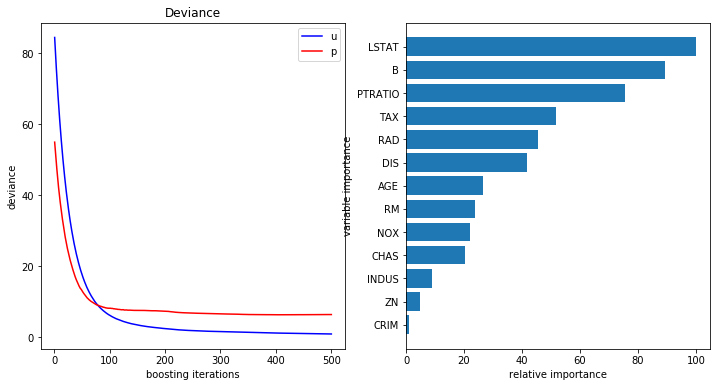

In [15]:
test_score = np.zeros(500, dtype = np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)
    
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1) # 1 строка 2 колонки
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-', label='training set deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-', label='test set deviance')

plt.legend('upper right')
plt.xlabel('boosting iterations')
plt.ylabel('deviance')



feature_importance = clf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, boston.feature_names)
plt.xlabel('relative importance')
plt.ylabel('variable importance')
plt.show()
